
# 🧠 Robust Multimodal Emotion & Strategy Classifier (ResNet + Audio + Text)

This notebook includes:
- Balanced CSV loading  
- Safe image/audio reading (graceful failure logging)  
- Debug mode with `num_workers=0`  
- Full train/val loop  
- Save and reload trained model


In [85]:

import os, random, json, numpy as np, pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Config
CSV_PATH = 'MESC_cleaned_balanced.csv'
FRAME_COLS = [f'Frame_{i}' for i in range(1,13)]
TEXT_COL, EMOTION_COL, STRATEGY_COL = 'Utterance','Emotion','Strategy'
SAMPLE_RATE, N_MELS = 16000, 128
BATCH_SIZE, EPOCHS, LR = 4, 3, 2e-4
NUM_WORKERS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [86]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()


C:\Users\Ezaz\AppData\Local\Temp\ipykernel_16436\2479615527.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [87]:

# Load CSV and encode
df = pd.read_csv(CSV_PATH).dropna(subset=[TEXT_COL,EMOTION_COL,STRATEGY_COL,'Audio']+FRAME_COLS)
le_e, le_s = LabelEncoder().fit(df[EMOTION_COL]), LabelEncoder().fit(df[STRATEGY_COL])
df['emotion_id'], df['strategy_id'] = le_e.transform(df[EMOTION_COL]), le_s.transform(df[STRATEGY_COL])
num_emotions, num_strategies = len(le_e.classes_), len(le_s.classes_)
print(num_emotions,"emotions", num_strategies,"strategies")
train_df, val_df = train_test_split(df,test_size=0.15,random_state=42,stratify=df['emotion_id'])


6 emotions 7 strategies


In [88]:
import os
from collections import OrderedDict

# ---- simple LRU for resampled waveforms (CPU tensors) ----
_AUDIO_CACHE: OrderedDict[str, tuple[int, int, torch.Tensor]] = OrderedDict()
_CACHE_MAX_ITEMS = 1024  # tweak as you like

def _cache_get(path: str, sr_out: int):
    try:
        mtime = int(os.path.getmtime(path))
    except Exception:
        return None
    key = f"{path}|{mtime}|{sr_out}"
    if key in _AUDIO_CACHE:
        # LRU touch
        _AUDIO_CACHE.move_to_end(key)
        return _AUDIO_CACHE[key][2].clone()  # return a clone so callers can modify
    return None

def _cache_put(path: str, sr_out: int, wav_cpu: torch.Tensor):
    try:
        mtime = int(os.path.getmtime(path))
    except Exception:
        return
    key = f"{path}|{mtime}|{sr_out}"
    _AUDIO_CACHE[key] = (mtime, sr_out, wav_cpu.contiguous().cpu())
    _AUDIO_CACHE.move_to_end(key)
    # Evict if over capacity
    while len(_AUDIO_CACHE) > _CACHE_MAX_ITEMS:
        _AUDIO_CACHE.popitem(last=False)


In [89]:

# Safe loaders
def safe_img(path):
    try:
        path=os.path.normpath(path)
        return Image.open(path).convert('L')
    except Exception as e:
        raise RuntimeError(f"Image failed: {path} -> {e}")
    


import math
import torch
import torch.nn.functional as F

# Preferred backends (no torchcodec)
try:
    import soundfile as sf
    HAVE_SF = True
except Exception:
    HAVE_SF = False

try:
    import librosa
    HAVE_LIBROSA = True
except Exception:
    HAVE_LIBROSA = False

try:
    from scipy.signal import resample_poly
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

import contextlib, wave, numpy as np

SAMPLE_RATE = 8000  # target (8 kHz)

def _to_mono_torch(x: torch.Tensor) -> torch.Tensor:
    # x: [T] or [C,T]; returns [T]
    if x.ndim == 2:
        x = x.mean(dim=0)
    return x

def _normalize_torch(x: torch.Tensor) -> torch.Tensor:
    # Map integer PCM to float [-1,1]
    if x.dtype in (torch.int16, torch.int32, torch.int64):
        x = x.to(torch.float32)
        # assume int16 if unknown
        x = x / 32768.0
    return x.to(torch.float32)

def _resample_torch(x: torch.Tensor, sr_in: int, sr_out: int, device=None) -> torch.Tensor:
    if sr_in == sr_out:
        return x
    # 1) SciPy: fast + high quality on CPU
    if HAVE_SCIPY:
        g = math.gcd(sr_in, sr_out)
        up = sr_out // g
        down = sr_in // g
        y = resample_poly(x.cpu().numpy(), up, down)
        return torch.from_numpy(y).to(device or x.device)
    # 2) GPU linear interpolate: fast and “good enough” for training
    y = x.to(device or x.device)
    T_in = y.shape[-1]
    T_out = int(round(T_in * sr_out / sr_in))
    y = F.interpolate(y.view(1,1,-1), size=T_out, mode="linear", align_corners=False).view(-1)
    return y


def _read_wav_stdlib(path: str):
    """
    Pure-stdlib WAV reader (PCM) -> (numpy float32 mono [T], sr)
    """
    with contextlib.closing(wave.open(path, 'rb')) as w:
        n_channels = w.getnchannels()
        sr = w.getframerate()
        n_frames = w.getnframes()
        sampwidth = w.getsampwidth()  # bytes per sample
        raw = w.readframes(n_frames)

    if sampwidth == 2:  # int16
        x = np.frombuffer(raw, dtype=np.int16).astype(np.float32) / 32768.0
    elif sampwidth == 1:  # u8
        x = (np.frombuffer(raw, dtype=np.uint8).astype(np.float32) - 128.0) / 128.0
    elif sampwidth == 4:  # int32 (rare for PCM wav), scale to [-1,1]
        x = np.frombuffer(raw, dtype=np.int32).astype(np.float32) / (2**31)
    else:
        # Fallback: just interpret as int16
        x = np.frombuffer(raw, dtype=np.int16).astype(np.float32) / 32768.0

    if n_channels > 1:
        x = x.reshape(-1, n_channels).mean(axis=1)  # mono mixdown
    return x.astype(np.float32), sr

def safe_audio(path: str) -> torch.Tensor:
    """
    Returns mono float32 waveform at SAMPLE_RATE (8 kHz), shape [T_8k], on CPU.
    Robust loaders (soundfile -> librosa -> stdlib wave) and cached resampling.
    """
    # 0) cache hit?
    cached = _cache_get(path, SAMPLE_RATE)
    if cached is not None:
        return cached

    try:
        # 1) soundfile (fast, if libsndfile available)
        if HAVE_SF:
            y, sr = sf.read(path, always_2d=False, dtype="float32")  # y: [T] or [T,C]
            if y.ndim == 2:
                y = y.mean(axis=1)
            wav = torch.from_numpy(y)

        # 2) librosa
        elif HAVE_LIBROSA:
            y, sr = librosa.load(path, sr=None, mono=True)  # float32 mono
            wav = torch.from_numpy(y)

        # 3) stdlib wave (PCM only)
        else:
            y, sr = _read_wav_stdlib(path)
            wav = torch.from_numpy(y)

        # resample to 8 kHz (prefers SciPy polyphase; else PyTorch interpolate)
        wav = _resample_torch(wav, sr, SAMPLE_RATE, device=torch.device("cpu"))

        # cleanup: DC remove, clamp peak
        wav = torch.nan_to_num(wav - wav.mean(), nan=0.0, posinf=0.0, neginf=0.0)
        m = wav.abs().max()
        if m > 1.0:
            wav = wav / m

        wav = wav.contiguous().cpu()
        _cache_put(path, SAMPLE_RATE, wav)  # <-- store CPU copy in LRU
        return wav.clone()

    except Exception as e:
        raise RuntimeError(f"Audio failed: {path} -> {e}")


In [90]:

img_tf=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
melspec=torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,n_mels=N_MELS)
amp2db=torchaudio.transforms.AmplitudeToDB()

class ClipDS(Dataset):
    def __init__(self,df):self.df=df.reset_index(drop=True)
    def __len__(self):return len(self.df)
    def __getitem__(self,i):
        try:
            row=self.df.loc[i]
            fr=[img_tf(safe_img(row[c])) for c in FRAME_COLS]
            wav=safe_audio(row['Audio'])
            mel=amp2db(melspec(wav)).squeeze(0).mean(-1)
            return {'utt':row[TEXT_COL],'frames_12':torch.stack(fr),
                    'audio_feat':mel,'emo':int(row['emotion_id']),'strat':int(row['strategy_id'])}
        except Exception as e:raise RuntimeError(f"Idx {i}: {e}")


In [91]:

def tok(texts,max_len=64):
    arr=[[ord(c)%10000 for c in t][:max_len] for t in texts]
    L=max(len(a) for a in arr)
    x=torch.zeros(len(arr),L).long()
    for i,a in enumerate(arr):x[i,:len(a)]=torch.tensor(a)
    return x,torch.ones_like(x)
def collate(b):
    ids,att=tok([x['utt'] for x in b])
    fr=torch.stack([x['frames_12'] for x in b])
    au=torch.stack([x['audio_feat'] for x in b])
    e=torch.tensor([x['emo'] for x in b]);s=torch.tensor([x['strat'] for x in b])
    return {'input_ids':ids,'att':att,'frames':fr,'audio':au,'emo':e,'strat':s}

train_dl=DataLoader(ClipDS(train_df),batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,collate_fn=collate)
val_dl=DataLoader(ClipDS(val_df),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate)
print("Train:",len(train_dl.dataset))


Train: 208


### Audio Feature Layer

In [92]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# ==== Binary STE pieces ====
class _SignSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, w): return w.sign()
    @staticmethod
    def backward(ctx, g): return g.clamp_(-1, 1)

def _bin_weight(w):  # per-output scale
    alpha = w.abs().mean(dim=1, keepdim=True).detach()
    return _SignSTE.apply(w) * alpha

class BinaryLinear(nn.Module):
    def __init__(self, in_f, out_f, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(out_f, in_f))
        self.bias = nn.Parameter(torch.zeros(out_f)) if bias else None
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if bias:
            bound = 1 / math.sqrt(in_f)
            nn.init.uniform_(self.bias, -bound, bound)
    def forward(self, x):
        return F.linear(x, _bin_weight(self.weight), self.bias)

# ==== Low-rank linear: float OR binary ====
class LowRankLinear(nn.Module):
    def __init__(self, in_f, out_f, rank, bias=True, binary=True):
        super().__init__()
        Lin = BinaryLinear if binary else nn.Linear
        self.l1 = Lin(in_f, rank, bias=False)
        self.l2 = Lin(rank, out_f, bias=bias)
    def forward(self, x):
        return self.l2(self.l1(x))

# ==== ALiBi bias ====
def _alibi(n_heads, T, device):
    m = 1 << (n_heads - 1).bit_length() - 1
    slopes = 2.0 ** (torch.arange(1, m+1, device=device).float() * (-2.0 / m))
    if m < n_heads:
        slopes = torch.cat([slopes, slopes[-1:].repeat(n_heads - m)])
    slopes = slopes.view(1, n_heads, 1, 1)
    t = torch.arange(T, device=device).view(1,1,1,T)
    return slopes * (t - t.transpose(-1, -2))  # [1,h,T,T]

# ==== Low-rank attention (hybrid float/binary per projection) ====
class LowRankMHA(nn.Module):
    def __init__(self, d=192, h=6, r=48, p=0.1,
                 q_bin=True, k_bin=True, v_bin=True, o_bin=True):
        super().__init__()
        assert d % h == 0
        self.h = h; self.dk = d // h
        self.q = LowRankLinear(d, d, r, binary=q_bin)
        self.k = LowRankLinear(d, d, r, binary=k_bin)
        self.v = LowRankLinear(d, d, r, binary=v_bin)
        self.o = LowRankLinear(d, d, r, binary=o_bin)
        self.ad = nn.Dropout(p); self.od = nn.Dropout(p)
    def forward(self, x, alibi=None, mask=None):
        B,T,D = x.shape
        q = self.q(x).view(B,T,self.h,self.dk).transpose(1,2)
        k = self.k(x).view(B,T,self.h,self.dk).transpose(1,2)
        v = self.v(x).view(B,T,self.h,self.dk).transpose(1,2)
        att = (q @ k.transpose(-1,-2)) / math.sqrt(self.dk)
        if alibi is not None: att = att + alibi[..., :T, :T]
        if mask is not None:  att = att.masked_fill(mask.unsqueeze(1)==0, float('-inf'))
        att = F.softmax(att, dim=-1); att = self.ad(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,D)
        return self.od(self.o(y))

class LowRankFFN(nn.Module):
    def __init__(self, d=192, dff=384, r=64, p=0.1, fc1_bin=True, fc2_bin=True):
        super().__init__()
        self.fc1 = LowRankLinear(d, dff, r, binary=fc1_bin)
        self.fc2 = LowRankLinear(dff, d, r, binary=fc2_bin)
        self.dr = nn.Dropout(p)
    def forward(self, x): return self.fc2(self.dr(F.gelu(self.fc1(x))))

class HybridBlock(nn.Module):
    def __init__(self, d=192, h=6, r_att=48, dff=384, r_ff=64, p=0.1,
                 q=True,k=True,v=True,o=True, fc1=True, fc2=True):
        super().__init__()
        self.n1 = nn.LayerNorm(d); self.n2 = nn.LayerNorm(d)
        self.att = LowRankMHA(d,h,r_att,p,q,k,v,o)
        self.ffn = LowRankFFN(d,dff,r_ff,p,fc1,fc2)
        self.d1 = nn.Dropout(p); self.d2 = nn.Dropout(p)
    def forward(self, x, alibi=None, mask=None):
        x = x + self.d1(self.att(self.n1(x), alibi, mask))
        x = x + self.d2(self.ffn(self.n2(x)))
        return x

# ---------- 8 kHz conv front-end (×160 stride -> ~50 Hz) with safe padding ----------
class FeatureEncoder8k(nn.Module):
    """
    8k waveform -> [B, T_frames, d_model]
    Strides: 5,2,2,2,2,2 => total ×160 => 8000/160 ≈ 50 fps
    Uses 'same-ish' padding so very short clips won't crash.
    """
    def __init__(self, d=192):
        super().__init__()
        def conv(i, o, k, s, p):  # p = padding
            return nn.Conv1d(i, o, kernel_size=k, stride=s, padding=p, bias=False)

        # 'same-ish' padding per layer:
        # k=10,s=5 -> p=5  ; k=3,s=2 -> p=1 ; k=2,s=2 -> p=1
        self.net = nn.Sequential(
            conv(1, d, 10, 5, 5), nn.GELU(),
            conv(d, d,  3, 2, 1), nn.GELU(),
            conv(d, d,  3, 2, 1), nn.GELU(),
            conv(d, d,  3, 2, 1), nn.GELU(),
            conv(d, d,  3, 2, 1), nn.GELU(),
            conv(d, d,  2, 2, 1), nn.GELU(),
        )
        self.post = nn.LayerNorm(d)

    def forward(self, wav):           # wav: [B, T_8k] or [T_8k]
        if wav.dim() == 1:
            wav = wav.unsqueeze(0)    # [1,T]
        # guard for very tiny clips (optional; 'same' padding already helps)
        if wav.size(-1) < 8:
            # pad to at least 8 samples (~1 ms) to avoid degenerate stats
            pad = 8 - wav.size(-1)
            wav = F.pad(wav, (0, pad))

        x = wav.unsqueeze(1)          # [B,1,T]
        x = self.net(x)               # [B,d,T/160 (ceil-like)]
        x = x.transpose(1, 2)         # [B,T',d]
        return self.post(x)


# ==== Full audio encoder (returns frame & utterance vectors) ====
class EmotionAudio8k(nn.Module):
    """
    8 kHz audio -> ~50 Hz frames -> Transformer (low-rank + hybrid binary/float)
    Float norms & final layers. Keeps some float linears to 'learn better'.
    Caches ALiBi so we don't re-create it every forward.
    """
    def __init__(self,
                 d=192, h=6, layers=8, r_att=48, dff=384, r_ff=64, dropout=0.1,
                 policy=None):
        super().__init__()
        self.fe = FeatureEncoder8k(d)
        if policy is None:
            policy = [{} for _ in range(layers)]
        assert len(policy) == layers

        blocks = []
        for i in range(layers):
            cfg = policy[i]
            blocks.append(HybridBlock(
                d,h,r_att,dff,r_ff,dropout,
                q=cfg.get('q',True),
                k=cfg.get('k',True),
                v=cfg.get('v',True),
                o=cfg.get('o',True),
                fc1=cfg.get('fc1',True),
                fc2=cfg.get('fc2',True),
            ))
        self.blocks = nn.ModuleList(blocks)
        self.final_norm = nn.LayerNorm(d)  # float

        # ---- ALiBi cache ----
        self.register_buffer("_alibi_cache", None, persistent=False)  # [1,H,Tmax,Tmax]
        self._alibi_H = 0
        self._alibi_Tmax = 0
        self._alibi_device = None

    @torch.no_grad()
    def _get_alibi(self, H: int, T: int, device: torch.device):
        # (re)build if heads changed, device changed, or we need a longer T
        need_rebuild = (
            self._alibi_cache is None or
            self._alibi_H != H or
            self._alibi_device != device or
            self._alibi_Tmax < T
        )
        if need_rebuild:
            self._alibi_cache = _alibi(H, T, device)   # build to current T
            self._alibi_H = H
            self._alibi_Tmax = T
            self._alibi_device = device
        # slice to requested T (safe if T <= Tmax)
        return self._alibi_cache[..., :T, :T]

    def forward(self, wav, mask=None, return_frame=True, return_utt=True):
        x = self.fe(wav)                 # [B,T',d]
        B, T, _ = x.shape
        H = self.blocks[0].att.h
        alibi = self._get_alibi(H, T, x.device)  # cached ALiBi
        for blk in self.blocks:
            x = blk(x, alibi, mask)
        x = self.final_norm(x)
        out = {}
        if return_frame: out['frame'] = x
        if return_utt:   out['utt']   = x.mean(1)
        return out


def audio_hybrid_policy(layers=8):
    # default all-binary per block
    base = dict(q=True, k=True, v=True, o=True, fc1=True, fc2=True)
    P = [base.copy() for _ in range(layers)]
    # Keep V and FFN.fc2 float in all blocks (stable value transport & output mix)
    for p in P:
        p['v'] = False
        p['fc2'] = False
    # Make block 0 and 4 fully-float in attention projections (Q/K/V/O)
    for i in [0, 4]:
        P[i]['q'] = False
        P[i]['k'] = False
        P[i]['v'] = False
        P[i]['o'] = False
    return P


### Vision Layer

In [93]:
from torchvision import models
import torch
import torch.nn as nn

# --- Vision backbone: MobileNetV3-Small for 1-channel input, outputs 576-d ---
def mobilenet_gray():
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

    # Replace first 3->C conv with 1->C conv and port averaged weights
    first = m.features[0][0]  # Conv2d inside ConvBNActivation
    w = first.weight.mean(1, keepdim=True).clone()  # [C,1,3,3]
    m.features[0][0] = nn.Conv2d(
        in_channels=1,
        out_channels=first.out_channels,
        kernel_size=first.kernel_size,
        stride=first.stride,
        padding=first.padding,
        bias=False,
    )
    m.features[0][0].weight.data = w

    # Make it a feature extractor (global pooled 576-d, classifier removed)
    m.classifier = nn.Identity()
    return m, 576

### Text Feature Layer

In [94]:


# --- Text encoder (lighter: same hidden size, fewer heads/layers) ---
class TxtEnc(nn.Module):
    def __init__(self, h=512):
        super().__init__()
        self.emb = nn.Embedding(10000, h)
        e = nn.TransformerEncoderLayer(h, 4, batch_first=True)  # heads=4 (was 8)
        self.enc = nn.TransformerEncoder(e, 1)                  # layers=1 (was 2)

    def forward(self, ids, att):
        x = self.emb(ids)
        return self.enc(x), x[:, 0, :]

import math
import torch
import torch.nn as nn

# --- Text-guided Top-K temporal pooling over frame features ---
class TextGuidedTopKPool(nn.Module):
    def __init__(self, d=512, k=6):
        super().__init__()
        self.k = k
        self.q = nn.Linear(d, d, bias=False)   # text -> query
        self.kp = nn.Linear(d, d, bias=False)  # frame -> key
        self.ln_t = nn.LayerNorm(d)
        self.ln_f = nn.LayerNorm(d)

    def forward(self, frames_d, text_vec):
        """
        frames_d: [B, T, d]  per-frame vision embeddings (T=12)
        text_vec: [B, d]     a text summary vector (e.g., CLS)
        returns: pooled [B,d], topk_idx [B,k], scores [B,T]
        """
        B, T, d = frames_d.shape
        q = self.ln_t(self.q(text_vec)).unsqueeze(1)      # [B,1,d]
        k = self.ln_f(self.kp(frames_d))                  # [B,T,d]
        scores = torch.matmul(q, k.transpose(-1, -2)).squeeze(1) / math.sqrt(d)  # [B,T]

        topk = torch.topk(scores, k=min(self.k, T), dim=-1)
        idx = topk.indices                                # [B,k]
        idx_exp = idx.unsqueeze(-1).expand(-1, -1, d)     # [B,k,d]
        sel = torch.gather(frames_d, 1, idx_exp)          # [B,k,d]
        pooled = sel.mean(1)                              # [B,d]
        return pooled, idx, scores

# --- Low-rank self-attention for strategy (as before) ---
class LowRankSelfAttn(nn.Module):
    def __init__(self, d_model=512, rank=64):
        super().__init__()
        self.rank = rank
        self.Wq = nn.Linear(d_model, rank, bias=False)
        self.Wk = nn.Linear(d_model, rank, bias=False)
        self.Wv = nn.Linear(d_model, rank, bias=False)
        self.Wo = nn.Linear(rank, d_model, bias=False)

    def forward(self, x, mask=None):
        Q = self.Wq(x); K = self.Wk(x); V = self.Wv(x)           # [B,T,r]
        att = (Q @ K.transpose(-1, -2)) / math.sqrt(self.rank)   # [B,T,T]
        if mask is not None:
            m = (mask > 0).unsqueeze(1).to(dtype=att.dtype)      # [B,1,T]
            att = att.masked_fill(m == 0, float('-inf'))
        att = torch.softmax(att, dim=-1)
        O_r = att @ V                                            # [B,T,r]
        return self.Wo(O_r)                                      # [B,T,d]

### Other Blocks

In [95]:
class BNNHeadStack(nn.Module):
    """
    ~500k-parameter binarized tower:
      512 ->(Binary)-> 512 -> GELU -> Dropout ->(Binary)-> 512
    Keep the final classifier float for stability.
    """
    def __init__(self, d=512, p=0.1):
        super().__init__()
        self.lin1 = BinaryLinear(d, d, bias=True)
        self.act  = nn.GELU()
        self.drop = nn.Dropout(p)
        self.lin2 = BinaryLinear(d, d, bias=True)

    def forward(self, x):
        x = self.lin2(self.drop(self.act(self.lin1(x))))
        return x
    

class HybridBNNHead(nn.Module):
    """
    ~500k-param binarized head:
      512 -(r=128)-> 512
          -(r=128)-> 512
          -(r=128)-> 512
          -(r=64 )-> 512
          -(r=32 )-> 512
      + float final classifier 512 -> num_classes

    Requires: LowRankLinear (binary=True) and BinaryLinear already defined.
    """
    def __init__(self, d=512, num_classes=8, ranks=(128,128,128,64,32), p=0.1, residual_every=2):
        super().__init__()
        self.d = d
        self.ranks = list(ranks)
        self.residual_every = max(1, residual_every)

        layers = []
        norms  = []
        for _ in self.ranks:
            norms.append(nn.LayerNorm(d))                                  # float LN
            layers.append(nn.Sequential(
                # low-rank binary 512->512 with rank r (set per layer at forward init)
                # we'll bind rank-specific modules below
                nn.Identity(),                                             # placeholder for LowRankLinear
                nn.GELU(),
                nn.Dropout(p),
            ))
        self.norms  = nn.ModuleList(norms)
        self.blocks = nn.ModuleList(layers)

        # materialize rank-specific LowRankLinear modules (binary)
        for i, r in enumerate(self.ranks):
            self.blocks[i][0] = LowRankLinear(d, d, rank=r, bias=True, binary=True)

        # float last layer (kept out of the ~500k binarized budget)
        self.classifier = nn.Linear(d, num_classes)

    @property
    def approx_binary_params(self):
        # sum r * (in+out) with in=out=self.d
        return int(sum(r * (self.d + self.d) for r in self.ranks))

    def forward(self, x):
        """
        x: [B, d=512]
        returns: logits [B, num_classes]
        """
        h = x
        for i, (ln, blk) in enumerate(zip(self.norms, self.blocks)):
            y = blk(ln(h))               # pre-norm
            # residual every K layers
            if (i + 1) % self.residual_every == 0:
                h = h + y
            else:
                h = y
        return self.classifier(h)



### Main Model

In [96]:
# --- Net with text-guided vision pooling (top-6 from 12) ---
class Net(nn.Module):
    def __init__(self, rank=64, k_top=6):
        super().__init__()
        # Vision
        self.v, v_dim = mobilenet_gray()         # [*,576]
        self.vp = nn.Linear(v_dim, 512)          # per-frame proj to 512
        self.v_pool = TextGuidedTopKPool(d=512, k=k_top)

        # Audio  (8 kHz wav -> ~50 Hz frames -> 192-d utt) + float proj to 512
        self.audio = EmotionAudio8k(
            d=192, h=6, layers=8, r_att=48, dff=384, r_ff=64,
            dropout=0.1, policy=audio_hybrid_policy(layers=8)
        )
        self.audio_out = nn.Linear(192, 512)     # float last layer

        # Text
        self.t = TxtEnc()                        # seq:[B,T,512], cls:[B,512]

        # EMOTION cross-attention (unchanged)
        self.q  = nn.Linear(512, 512)
        self.k  = nn.Linear(512, 512)
        self.vv = nn.Linear(512, 512)
        self.att = nn.MultiheadAttention(512, 8, batch_first=True)

        # Heads (≈500k binarized tower before each float classifier)
        self.emo_head   = HybridBNNHead(d=512, num_classes=num_emotions)
        # STRATEGY branch: low-rank text self-attn + AV residual + BNN head
        self.self_lr = LowRankSelfAttn(d_model=512, rank=rank)
        self.norm_s  = nn.LayerNorm(512)
        self.strat_head = HybridBNNHead(d=512, num_classes=num_strategies)

    def forward(self, fr, au_wav, t):
        """
        Inputs:
          fr:     [B, 12, 1, 128, 128]        # 12 grayscale frames
          au_wav: [B, T_8k]                    # raw 8 kHz waveform
          t:      {'input_ids':[B,T], 'att':[B,T]}
        Returns:
          emo   : [B, num_emotions]
          strat : [B, num_strategies]
          extras: {'topk_frame_idx':[B,k], 'frame_scores':[B,12]}
        """
        B = fr.size(0)

        # --- Text first (we need CLS to guide vision selection) ---
        seq, cls = self.t(t['input_ids'], t['att'])    # seq:[B,T,512], cls:[B,512]

        # --- Vision: per-frame features, then text-guided Top-K pooling ---
        vf = self.v(fr.view(B * 12, 1, 128, 128))      # [B*12,576]
        vf = vf.view(B, 12, -1)                        # [B,12,576]
        vf512 = self.vp(vf)                            # [B,12,512]  (per-frame projection)
        v_guided, top_idx, v_scores = self.v_pool(vf512, cls)  # pooled [B,512]

        # --- Audio (8 kHz raw -> utt 192 -> proj 512) ---
        a_dict = self.audio(au_wav)                    # {'frame':[B,T',192], 'utt':[B,192]}
        a = self.audio_out(a_dict['utt'])              # [B,512]

        # --- A+V fuse (use guided V now) ---
        av = (v_guided + a) / 2                        # [B,512]
        av_seq = av.unsqueeze(1)                       # [B,1,512]

        # ===================== EMOTION =====================
        q, k, vv = self.q(seq), self.k(av_seq), self.vv(av_seq)
        o, _ = self.att(q, k, vv)                      # [B,T,512]
        fz = o[:, 0, :]                                # first token
        emo = self.emo_head(fz)                        # ~500k binarized tower + float logits

        # ===================== STRATEGY =====================
        s_seq = self.self_lr(seq, mask=t.get('att', None))   # [B,T,512]
        s_tok = s_seq[:, 0, :]                               # [B,512]
        s_fused = self.norm_s(s_tok + av)                    # residual add with AV
        strat = self.strat_head(s_fused)                     # ~500k binarized tower + float logits

        # (optionally return indices/scores for inspection)
        return emo, strat, {'topk_frame_idx': top_idx, 'frame_scores': v_scores}


model = Net().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
ce = nn.CrossEntropyLoss()


In [98]:
from tqdm import tqdm

# set to a positive integer (e.g., 100) to peek at aux every N steps; 0 disables
SHOW_AUX_EVERY = 3  # e.g., 100

def _unpack_outputs(model_out):
    """Accept (emo,strat) or (emo,strat,aux) without breaking."""
    if isinstance(model_out, (tuple, list)):
        if len(model_out) == 2:
            emo_pred, strat_pred = model_out
            aux = None
        elif len(model_out) == 3:
            emo_pred, strat_pred, aux = model_out
        else:
            raise ValueError(f"Model returned {len(model_out)} items; expected 2 or 3.")
    else:
        raise ValueError("Model output must be a tuple/list of length 2 or 3.")
    return emo_pred, strat_pred, aux

def run_epoch(model, dl, train=True):
    model.train(train)
    total_emo_loss, total_str_loss = 0.0, 0.0
    correct_emo, correct_str = 0, 0
    total_samples = 0

    phase = "Train" if train else "Val"
    pbar = tqdm(dl, desc=f"{phase} epoch", leave=False)
    step = 0

    for batch in pbar:
        # ---------------- Inputs ----------------
        frames = batch['frames'].to(device, non_blocking=True)
        audio  = batch['audio'].to(device,  non_blocking=True)
        emo_gt = batch['emo'].to(device,    non_blocking=True)
        strat_gt = batch['strat'].to(device, non_blocking=True)
        text = {
            'input_ids': batch['input_ids'].to(device, non_blocking=True),
            'att':       batch['att'].to(device,       non_blocking=True)
        }

        # ---------------- Forward / Backward ----------------
        with torch.set_grad_enabled(train):
            with autocast( dtype=torch.float16):   # ✅ FP16 autocast
                out = model(frames, audio, text)
                emo_pred, strat_pred, aux = _unpack_outputs(out)
                loss_emo = ce(emo_pred, emo_gt)
                loss_str = ce(strat_pred, strat_gt)
                total_loss = loss_emo + loss_str

            if train:
                opt.zero_grad(set_to_none=True)
                scaler.scale(total_loss).backward()
                scaler.step(opt)
                scaler.update()


        # ---------------- Metrics ----------------
        bs = frames.size(0)
        total_samples  += bs
        total_emo_loss += loss_emo.item() * bs
        total_str_loss += loss_str.item() * bs
        correct_emo    += (emo_pred.argmax(1) == emo_gt).sum().item()
        correct_str    += (strat_pred.argmax(1) == strat_gt).sum().item()

        # live display
        postfix = {
            "EmoLoss": f"{loss_emo.item():.3f}",
            "StrLoss": f"{loss_str.item():.3f}"
        }

        # Optional: peek at aux (top-k frame selection) every N steps if available
        if SHOW_AUX_EVERY and aux is not None and (step % SHOW_AUX_EVERY == 0):
            # show the first sample's topk indices to avoid verbosity
            tk = aux.get("topk_frame_idx", None)
            if tk is not None:
                idx0 = tk[0].tolist() if hasattr(tk, "tolist") else tk[0]
                postfix["TopK(fr0)"] = str(idx0)

        pbar.set_postfix(postfix)
        step += 1

    avg_emo_loss = total_emo_loss / max(1, total_samples)
    avg_str_loss = total_str_loss / max(1, total_samples)
    emo_acc = correct_emo / max(1, total_samples)
    strat_acc = correct_str / max(1, total_samples)

    return {
        "emo_loss": avg_emo_loss,
        "emo_acc": emo_acc,
        "str_loss": avg_str_loss,
        "str_acc": strat_acc
    }

# ---------------- Training Loop ----------------
history = []
for ep in range(1, 2 + 1):
    print(f"\n🟩 Epoch {ep}/{EPOCHS}")
    train_metrics = run_epoch(model, train_dl, True)

    # eval with no grad (model.train(False) is set inside)
    with torch.no_grad():
        val_metrics = run_epoch(model, val_dl, False)

    print(f"📊 Train — "
          f"Emotion Loss: {train_metrics['emo_loss']:.4f}, "
          f"Acc: {train_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {train_metrics['str_loss']:.4f}, "
          f"Acc: {train_metrics['str_acc']*100:.2f}%")

    print(f"🧪 Val   — "
          f"Emotion Loss: {val_metrics['emo_loss']:.4f}, "
          f"Acc: {val_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {val_metrics['str_loss']:.4f}, "
          f"Acc: {val_metrics['str_acc']*100:.2f}%")

    history.append((train_metrics, val_metrics))


# 1) get a FP16 copy of just the weights (doesn't mutate your live model)
fp16_state = {k: v.half() if torch.is_floating_point(v) else v
              for k, v in model.state_dict().items()}

torch.save(fp16_state, "model_fp16_weights.pt")   # ~half the size on disk

print("\n✅ Model saved as robust_avt_model.pth")



🟩 Epoch 1/3


Train epoch:   0%|          | 0/52 [00:00<?, ?it/s]C:\Users\Ezaz\AppData\Local\Temp\ipykernel_16436\1314212568.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast( dtype=torch.float16):   # ✅ FP16 autocast


📊 Train — Emotion Loss: 1.1731, Acc: 59.62% | Strategy Loss: 1.0645, Acc: 61.54%
🧪 Val   — Emotion Loss: 3.4233, Acc: 18.92% | Strategy Loss: 1.1253, Acc: 54.05%

🟩 Epoch 2/3


📊 Train — Emotion Loss: 1.2313, Acc: 62.02% | Strategy Loss: 0.9229, Acc: 70.67%
🧪 Val   — Emotion Loss: 2.8835, Acc: 18.92% | Strategy Loss: 1.1519, Acc: 59.46%

✅ Model saved as robust_avt_model.pth


In [ ]:
from PIL import Image
import torch
def predict_sample(model, frame_paths, audio_path, utterance, le_emotion, le_strategy):
    model.eval()
    device = next(model.parameters()).device
    dtype  = next(model.parameters()).dtype  # will be torch.float16 if you saved/loaded FP16

    # --- Preprocess frames ---
    frames = [img_tf(safe_img(p)) for p in frame_paths]   # each -> [1,128,128] float32 CPU
    frames = torch.stack(frames).unsqueeze(0)                   # [1,12,1,128,128]
    frames = frames.to(device=device, dtype=dtype)              # <-- cast to model dtype (FP16)

    # --- Preprocess audio ---
    wav = safe_audio(audio_path)
    mel = amp2db(melspec(wav)).squeeze(0).mean(-1)              # [N_MELS] float32 CPU
    mel = mel.unsqueeze(0).to(device=device, dtype=dtype)       # <-- cast to FP16

    # --- Text tokens ---
    ids, att = tok([utterance])                                 # ids: long; att: long/bool
    text = {'input_ids': ids.to(device), 'att': att.to(device)} # keep ints as-is

    with torch.no_grad():
        out = model(frames, mel, text)
        if isinstance(out, (tuple, list)) and len(out) == 3:
            emo_pred, strat_pred, aux = out
        else:
            emo_pred, strat_pred = out
            aux = None

    emo_id   = emo_pred.argmax(1).item()
    strat_id = strat_pred.argmax(1).item()

    return le_emotion.inverse_transform([emo_id])[0], \
           le_strategy.inverse_transform([strat_id])[0], aux


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def show_prediction_sample(model, df, le_emotion, le_strategy):
    """
    Randomly picks one row from df, visualizes 12 frames, plays audio,
    runs the model, prints predictions vs ground truth, and shows the
    Top-K frame indices chosen by text-guided pooling.
    Returns: (row, aux) where aux may include 'topk_frame_idx' and 'frame_scores'.
    """

    # ---- pick a row ----
    row = df.sample(1).iloc[0]
    frame_paths = [row[f] for f in FRAME_COLS]   # assumes FRAME_COLS is defined globally
    audio_path  = row['Audio']
    utterance   = row['Utterance']

    print("="*90)
    print(f"🎬 Utterance: {utterance}")
    print(f"🎧 Audio: {audio_path}")
    print("="*90)

    # ---- show all 12 frames ----
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i, (ax, path) in enumerate(zip(axes.flatten(), frame_paths)):
        try:
            img = Image.open(path).convert("L")
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Frame {i}", fontsize=10)  # 0-based so it matches indices
            ax.axis("off")
        except Exception:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center')
            ax.axis("off")
    plt.tight_layout()
    plt.show()

    # ---- play audio ----
    print("🔊 Playing audio:")
    display(Audio(audio_path, autoplay=False))

    # ---- run prediction ----
    pred_emotion, pred_strategy, aux = predict_sample(
        model,
        frame_paths=frame_paths,
        audio_path=audio_path,
        utterance=utterance,
        le_emotion=le_emotion,
        le_strategy=le_strategy
    )

    # ---- show which frames were picked (Top-K) ----
    if aux is not None and "topk_frame_idx" in aux:
        sel_idx = aux["topk_frame_idx"][0].tolist()  # selected indices for this single sample
        print("\n✅ Top-K selected frame indices:", sel_idx)

        # visualize only the selected frames in order of selection
        cols = len(sel_idx)
        plt.figure(figsize=(2.2*cols, 2.6))
        for i, idx in enumerate(sel_idx):
            try:
                img = Image.open(frame_paths[idx]).convert("L")
                plt.subplot(1, cols, i+1)
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.title(f"#{idx}")
            except Exception:
                plt.subplot(1, cols, i+1)
                plt.axis('off')
                plt.title(f"#{idx} (missing)")
        plt.tight_layout()
        plt.show()

    # ---- print summary (pred vs true) ----
    true_emotion  = row[EMOTION_COL]     # assumes EMOTION_COL defined
    true_strategy = row[STRATEGY_COL]    # assumes STRATEGY_COL defined
    print("\n================= RESULT SUMMARY =================")
    print(f"🧩 Predicted Emotion:  {pred_emotion}")
    print(f"🗣️  Predicted Strategy: {pred_strategy}")
    print(f"🎯 True Emotion:        {true_emotion}")
    print(f"🎯 True Strategy:       {true_strategy}")
    print("===================================================")

    return row, aux


🎬 Utterance: I don't wanna be put in this position. I don't wanna have this power to decide our future for both of us. I just don't.
🎧 Audio: audio\Dialogue_ID-9_Season-1_Episode-1_00-18-09.400_00-18-14.948.wav


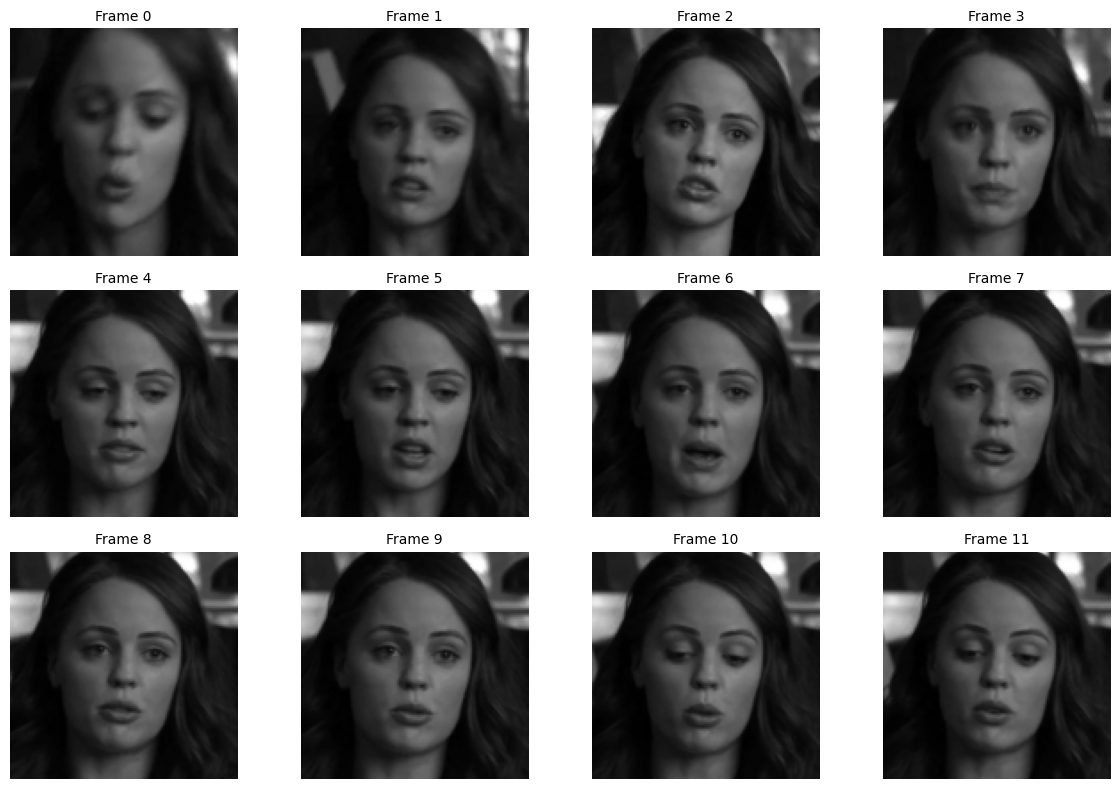

🔊 Playing audio:



✅ Top-K selected frame indices: [0, 10, 4, 6, 9, 11]


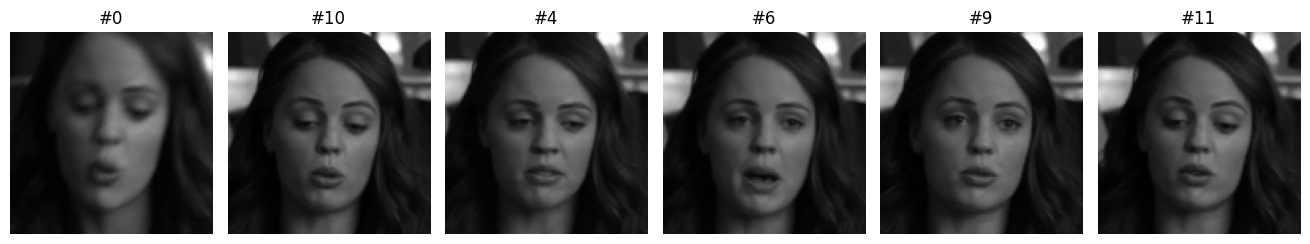


================= RESULT SUMMARY =================
🧩 Predicted Emotion:  disgust
🗣️  Predicted Strategy: Open question
🎯 True Emotion:        disgust
🎯 True Strategy:       Open question


(Dialogue_ID                                                     9
 split_group                                                     3
 Season                                                          1
 Episode                                                         1
 StartTime                                            00:18:09,400
 EndTime                                              00:18:14,948
 Speaker                                                    Client
 Utterance       I don't wanna be put in this position. I don't...
 Emotion                                                   disgust
 Strategy                                            Open question
 Utterance_ID                                                    3
 Frame_1         frames\Dialogue_ID-9_Season-1_Episode-1_f01_t0...
 Frame_2         frames\Dialogue_ID-9_Season-1_Episode-1_f02_t0...
 Frame_3         frames\Dialogue_ID-9_Season-1_Episode-1_f03_t0...
 Frame_4         frames\Dialogue_ID-9_Season-1_Episode-1_f04_t

In [ ]:

# Load trained model and encoders first (if not already)
model_loaded = Net().to(device).half()  # load in FP16 mode
model_loaded.load_state_dict(torch.load("model_fp16_weights.pt", map_location=device))
model_loaded.eval()

# Now predict on a random CSV row
show_prediction_sample(model_loaded, df, le_e, le_s)

